In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [78]:
TICKERS = ['JNJ', 'GS', 'AAPL', 'XOM', 'NVDA']
START_DATE = '2015-01-01'
END_DATE = '2025-06-10'

for ticker in TICKERS:
    print(f"\n Downloading data for: {ticker}")
    
    data = yf.download(ticker, start=START_DATE, end=END_DATE)
    data.dropna(inplace=True)

    print(f" Data shape for {ticker}: {data.shape}")
    print(data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Data shape for JNJ: (2624, 5)
Price            Close        High         Low        Open   Volume
Ticker             JNJ         JNJ         JNJ         JNJ      JNJ
Date                                                               
2025-06-03  154.419998  155.660004  154.080002  154.800003  8209800
2025-06-04  153.220001  154.929993  153.130005  154.929993  6983900
2025-06-05  153.660004  154.089996  152.639999  153.679993  5295400
2025-06-06  155.029999  156.029999  154.000000  154.000000  5391500
2025-06-09  155.229996  155.990005  154.449997  154.850006  5319000

 Data shape for GS: (2624, 5)
Price            Close        High         Low       Open   Volume
Ticker              GS          GS          GS         GS       GS
Date                                                              
2025-06-03  603.830017  606.320007  593.729980  600.00000  1730300
2025-06-04  599.210022  606.330017  598.719971  605.47998  1294900
2025-06-05  605.880005  609.719971  592.900024  600.00000  

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Data shape for AAPL: (2624, 5)
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-06-03  203.270004  203.770004  200.960007  201.350006  46381600
2025-06-04  202.820007  206.240005  202.100006  202.910004  43604000
2025-06-05  200.630005  204.750000  200.149994  203.500000  55126100
2025-06-06  203.919998  205.699997  202.050003  203.000000  46607700
2025-06-09  201.449997  206.000000  200.020004  204.389999  72862600

 Data shape for XOM: (2624, 5)
Price            Close        High         Low        Open    Volume
Ticker             XOM         XOM         XOM         XOM       XOM
Date                                                                
2025-06-03  103.800003  104.660004  102.209999  102.900002  19194300
2025-06-04  102.300003  104.919998  102.300003  103.919998  15648500
2025-06-05  101.830002  103.050003  101

[*********************100%***********************]  1 of 1 completed

 Data shape for NVDA: (2624, 5)
Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2025-06-03  141.210190  141.990134  137.940413  138.770357  225578800
2025-06-04  141.910141  142.380110  139.530301  142.180127  167120800
2025-06-05  139.980286  143.990002  138.820363  142.160127  231397900
2025-06-06  141.710159  143.260055  141.500167  142.500098  153986200
2025-06-09  142.620102  144.989932  141.930147  143.180061  185114500


In [79]:
def create_lstm_sequences(df, window_size=60):
    close_data = df[['Close']]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(close_data)

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [80]:
WINDOW_SIZE = 60
stock_data = {}    
lstm_data = {}     

for ticker in TICKERS:
    try:
        
        df = yf.download(ticker, start=START_DATE, end=END_DATE)
        df.dropna(inplace=True)
        stock_data[ticker] = df

       
        X, y, scaler = create_lstm_sequences(df, window_size=WINDOW_SIZE)
        lstm_data[ticker] = {
            "X": X,
            "y": y,
            "scaler": scaler,
            "raw": df
        }

        print(f"{ticker} processed: X shape = {X.shape}, y shape = {y.shape}")

    except Exception as e:
        print(f" Error with {ticker}: {e}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


JNJ processed: X shape = (2564, 60, 1), y shape = (2564,)
GS processed: X shape = (2564, 60, 1), y shape = (2564,)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

AAPL processed: X shape = (2564, 60, 1), y shape = (2564,)
XOM processed: X shape = (2564, 60, 1), y shape = (2564,)
NVDA processed: X shape = (2564, 60, 1), y shape = (2564,)


In [81]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

EPOCHS = 10
BATCH_SIZE = 32
models = {}

for ticker in lstm_data:
    print(f"\nTraining model for {ticker}...")

    X = lstm_data[ticker]['X']
    y = lstm_data[ticker]['y']

    model = Sequential([
        Input(shape=(X.shape[1], 1)),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    models[ticker] = model
    print(f" {ticker} model trained.")


Training model for JNJ...
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0782
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0041
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0036
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0034
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0031
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0027
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0024
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0023
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0019
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0020
 JNJ model trained.

Training model for GS...
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0155
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0014
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0017
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0013
Ep

In [101]:
for ticker in TICKERS:
    try:
        model = models[ticker]
        scaler = lstm_data[ticker]['scaler']
        df = lstm_data[ticker]['raw']

        last_60_days = df[['Close']].values[-WINDOW_SIZE:]
        last_60_scaled = scaler.transform(last_60_days)
        input_sequence = last_60_scaled.reshape(1, WINDOW_SIZE, 1)

        predicted_scaled_price = model.predict(input_sequence, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_scaled_price)

        last_date = df.index[-1]
        last_price = df['Close'].iloc[-1].item()
        next_date = last_date + pd.Timedelta(days=1)

        print(f"{ticker}")
        print(f"Last Date: {last_date.date()} | Actual: ${last_price:.2f}")
        print(f"Predicted Next Date: {next_date.date()} | Predicted: ${predicted_price[0][0]:.2f}\n")

    except Exception as e:
        print(f"Error predicting {ticker}: {e}")

JNJ
Last Date: 2025-06-09 | Actual: $155.23
Predicted Next Date: 2025-06-10 | Predicted: $154.41

GS
Last Date: 2025-06-09 | Actual: $613.52
Predicted Next Date: 2025-06-10 | Predicted: $608.04

AAPL
Last Date: 2025-06-09 | Actual: $201.45
Predicted Next Date: 2025-06-10 | Predicted: $197.88

XOM
Last Date: 2025-06-09 | Actual: $104.97
Predicted Next Date: 2025-06-10 | Predicted: $103.82

NVDA
Last Date: 2025-06-09 | Actual: $142.62
Predicted Next Date: 2025-06-10 | Predicted: $133.60



In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

eval_results = {}

for ticker in TICKERS:
    try:
        df = stock_data[ticker][['Close']]
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df)

        split_index = int(len(scaled) * 0.8)
        train_data = scaled[:split_index]
        test_data = scaled[split_index - WINDOW_SIZE:]

        X_test, y_test = [], []

        for i in range(WINDOW_SIZE, len(test_data)):
            X_test.append(test_data[i - WINDOW_SIZE:i, 0])
            y_test.append(test_data[i, 0])

        X_test = np.array(X_test).reshape(-1, WINDOW_SIZE, 1)
        y_test = np.array(y_test)

        model = models[ticker]
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)
        y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

        rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
        mae = mean_absolute_error(y_test_rescaled, predictions)

        eval_results[ticker] = {"RMSE": rmse, "MAE": mae}
        print(f"{ticker} — RMSE: {rmse:.4f} | MAE: {mae:.4f}")

    except Exception as e:
        print(f"Error evaluating {ticker}: {e}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
JNJ — RMSE: 3.0303 | MAE: 2.3808
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
GS — RMSE: 15.8211 | MAE: 10.7194
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AAPL — RMSE: 8.4463 | MAE: 6.6743
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
XOM — RMSE: 2.9152 | MAE: 2.2550
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
NVDA — RMSE: 7.0093 | MAE: 5.4003


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


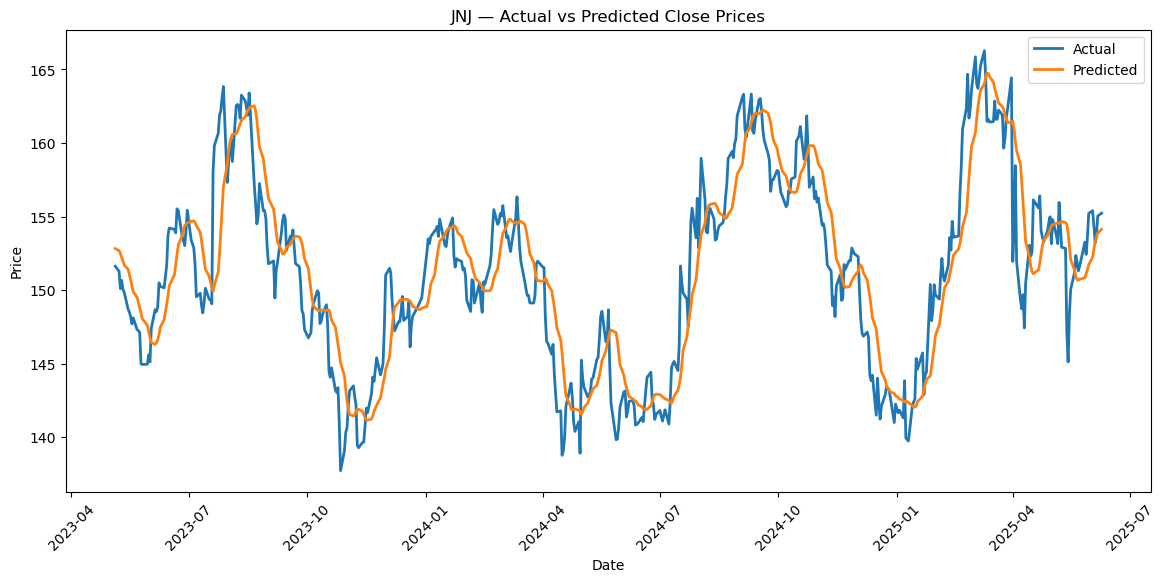

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


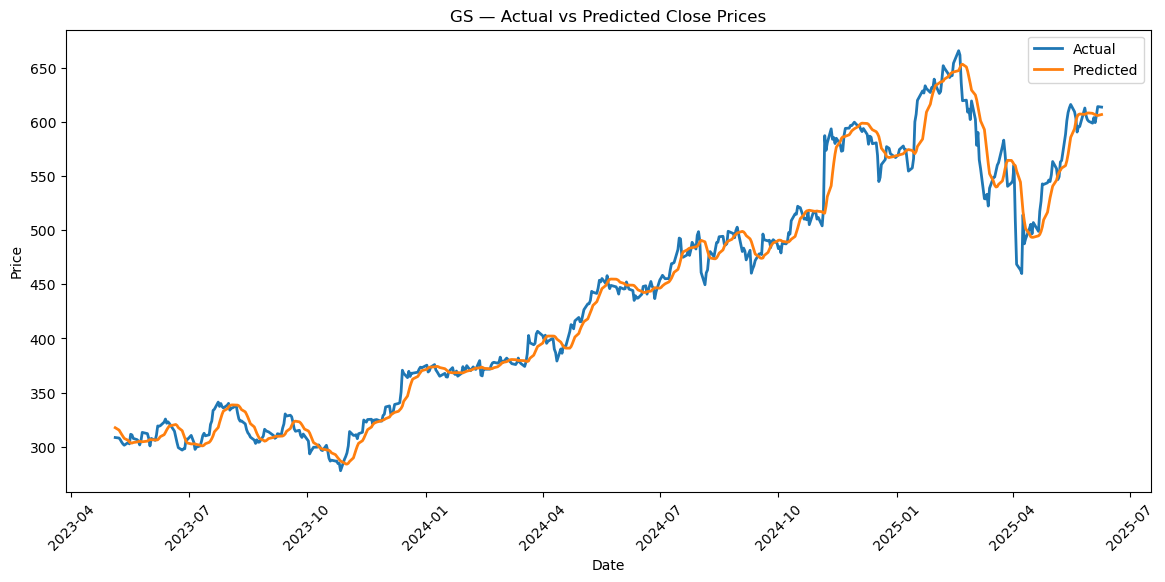

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


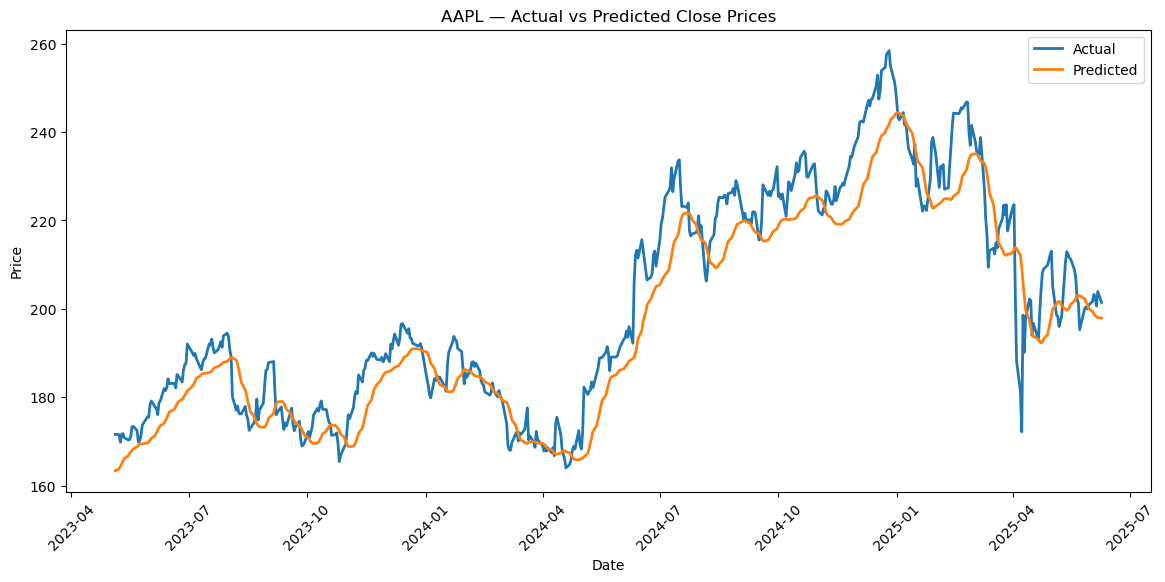

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


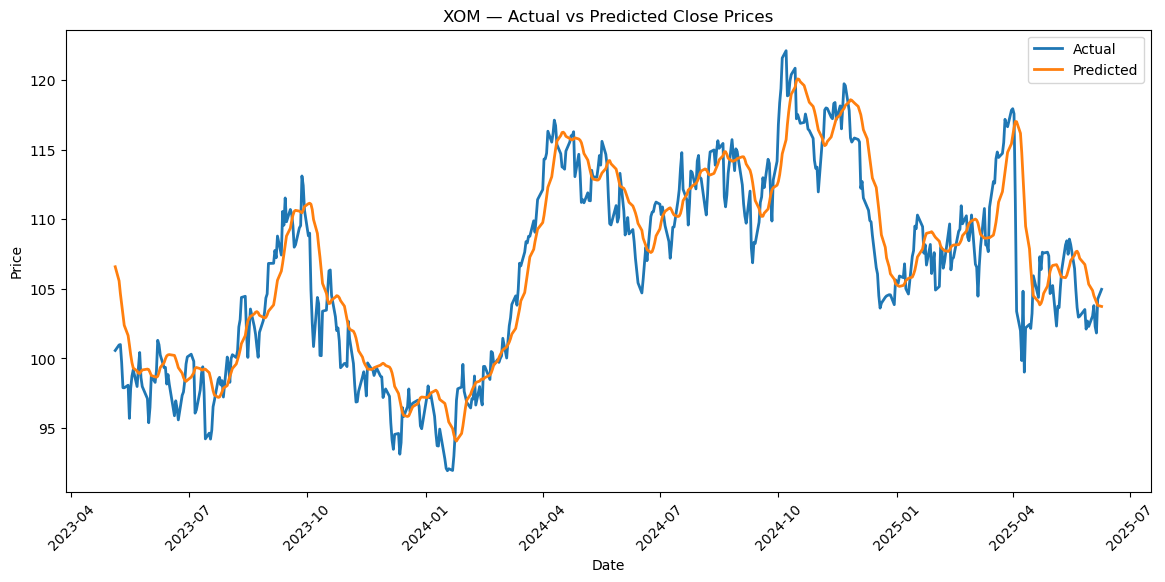

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


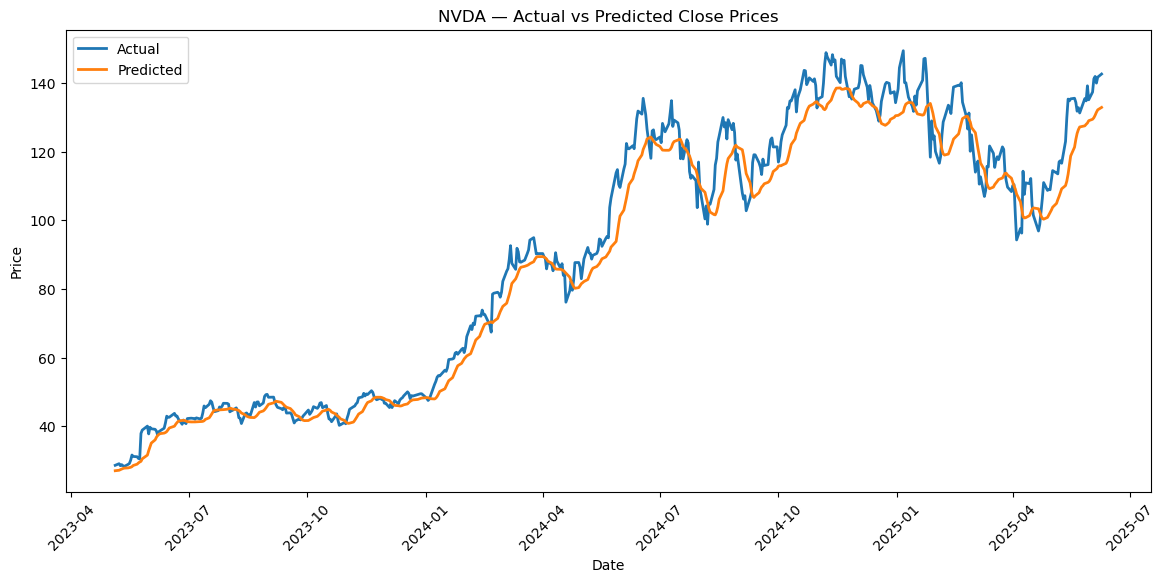

In [109]:
for ticker in TICKERS:
    try:
        df = stock_data[ticker][['Close']]
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df)

        split_index = int(len(scaled) * 0.8)
        test_data = scaled[split_index - WINDOW_SIZE:]
        date_index = df.index[split_index:]

        X_test, y_test = [], []

        for i in range(WINDOW_SIZE, len(test_data)):
            X_test.append(test_data[i - WINDOW_SIZE:i, 0])
            y_test.append(test_data[i, 0])

        X_test = np.array(X_test).reshape(-1, WINDOW_SIZE, 1)
        y_test = np.array(y_test)

        model = models[ticker]
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)
        y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

        plt.figure(figsize=(14, 6))
        plt.plot(date_index, y_test_rescaled, label='Actual', linewidth=2)
        plt.plot(date_index, predictions, label='Predicted', linewidth=2)
        plt.title(f'{ticker} — Actual vs Predicted Close Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

    except Exception as e:
        print(f"Error plotting {ticker}: {e}")

In [111]:
import pandas as pd

results_df = pd.DataFrame(eval_results).T 

sorted_by_rmse = results_df.sort_values(by='RMSE')
sorted_by_mae = results_df.sort_values(by='MAE')

print("▼ Sorted by RMSE (Best to Worst):")
print(sorted_by_rmse)

print("\n▼ Sorted by MAE (Best to Worst):")
print(sorted_by_mae)

▼ Sorted by RMSE (Best to Worst):
           RMSE        MAE
XOM    2.915227   2.254980
JNJ    3.030304   2.380789
NVDA   7.009309   5.400262
AAPL   8.446267   6.674273
GS    15.821131  10.719387

▼ Sorted by MAE (Best to Worst):
           RMSE        MAE
XOM    2.915227   2.254980
JNJ    3.030304   2.380789
NVDA   7.009309   5.400262
AAPL   8.446267   6.674273
GS    15.821131  10.719387


In [113]:
from pandas.tseries.offsets import BDay

forecast_horizon = 7
multi_day_predictions = {}

for ticker in TICKERS:
    try:
        model = models[ticker]
        scaler = lstm_data[ticker]['scaler']
        df = lstm_data[ticker]['raw']

        # We are using the last 60 actual Close prices to predict future Close prices
        last_close = df[['Close']].values[-WINDOW_SIZE:]
        last_scaled = scaler.transform(last_close)
        current_window = last_scaled.reshape(1, WINDOW_SIZE, 1)

        forecast = []
        last_date = df.index[-1]

        for i in range(1, forecast_horizon + 1):
            # Predict the next day's closing price (scaled)
            pred_scaled = model.predict(current_window, verbose=0)
            # Inverse transform to get predicted closing price in actual dollar terms
            pred_price = scaler.inverse_transform(pred_scaled)[0][0]
            pred_price = round(pred_price, 2)

            forecast_date = last_date + BDay(i)
            forecast.append((forecast_date, pred_price))

            # Slide the window to include this prediction for next step
            next_input = np.append(current_window[:, 1:, :], [[[pred_scaled[0][0]]]], axis=1)
            current_window = next_input

        multi_day_predictions[ticker] = forecast

        print(f"\n{ticker} — Next {forecast_horizon} Business Days Forecast (Predicted Close Prices):")
        for date, price in forecast:
            print(f"{date.date()} → ${price:.2f}")

    except Exception as e:
        print(f"Error forecasting {ticker}: {e}")


JNJ — Next 7 Business Days Forecast (Predicted Close Prices):
2025-06-10 → $154.41
2025-06-11 → $154.61
2025-06-12 → $154.76
2025-06-13 → $154.89
2025-06-16 → $154.99
2025-06-17 → $155.07
2025-06-18 → $155.15

GS — Next 7 Business Days Forecast (Predicted Close Prices):
2025-06-10 → $608.04
2025-06-11 → $609.10
2025-06-12 → $609.98
2025-06-13 → $610.75
2025-06-16 → $611.46
2025-06-17 → $612.13
2025-06-18 → $612.78

AAPL — Next 7 Business Days Forecast (Predicted Close Prices):
2025-06-10 → $197.88
2025-06-11 → $197.68
2025-06-12 → $197.39
2025-06-13 → $197.02
2025-06-16 → $196.59
2025-06-17 → $196.13
2025-06-18 → $195.64

XOM — Next 7 Business Days Forecast (Predicted Close Prices):
2025-06-10 → $103.82
2025-06-11 → $103.92
2025-06-12 → $104.04
2025-06-13 → $104.18
2025-06-16 → $104.32
2025-06-17 → $104.47
2025-06-18 → $104.62

NVDA — Next 7 Business Days Forecast (Predicted Close Prices):
2025-06-10 → $133.60
2025-06-11 → $133.46
2025-06-12 → $132.88
2025-06-13 → $132.07
2025-06-16 →

In [129]:
import pickle

with open("forecast_results.pkl", "wb") as f:
    pickle.dump({
        "multi_day_predictions": multi_day_predictions,
        "eval_results": eval_results
    }, f)

In [131]:
from datetime import timedelta

actual_vs_predicted = {}

for ticker in TICKERS:
    try:
        model = models[ticker]
        scaler = lstm_data[ticker]['scaler']
        df = stock_data[ticker][['Close']]
        
        scaled = scaler.fit_transform(df)
        split_index = int(len(scaled) * 0.8)
        test_data = scaled[split_index - WINDOW_SIZE:]
        date_index = df.index[split_index:]

        X_test, y_test = [], []

        for i in range(WINDOW_SIZE, len(test_data)):
            X_test.append(test_data[i - WINDOW_SIZE:i, 0])
            y_test.append(test_data[i, 0])

        X_test = np.array(X_test).reshape(-1, WINDOW_SIZE, 1)
        y_test = np.array(y_test)

        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions).flatten()
        actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        dates = date_index[-len(predictions):]

        actual_vs_predicted[ticker] = {
            "actual": actual.tolist(),
            "predicted": predictions.tolist(),
            "dates": dates.strftime('%Y-%m-%d').tolist()
        }

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

with open("actual_vs_predicted.pkl", "wb") as f:
    pickle.dump(actual_vs_predicted, f)

print(" actual_vs_predicted.pkl saved successfully.")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 actual_vs_predicted.pkl saved successfully.
